In [1]:
import utils.utils as utils
import models.xgboost_model as xgb_model
import pandas as pd
import numpy as np

In [2]:
def get_pitch_data():
    # Read csv files of saved pitch data from the MLB 2016-2019 seasons
    pitch_data = pd.read_csv('raw_pitch_data_all_base_v2.csv', index_col=0)
    print("pitch data loaded")
    return pitch_data

def filter_pitch_data(pitch_data):
    pre_filter_rows = len(pitch_data.index)
    pitch_data = pitch_data[pd.notnull(pitch_data['p1_pitch_type'])]
    post_filter_rows = len(pitch_data.index)

    filter_diff = pre_filter_rows - post_filter_rows
    filter_pcnt = (filter_diff)/pre_filter_rows

    print('Removed Null/NaN labeled pitch types rows, filtered %d of %d rows at %f%%' % (filter_diff, pre_filter_rows, filter_pcnt))
    return pitch_data

def drop_pitch_types(pitch_data):
    #
    # Drop rows with unwanted pitchtypes (including automatic ball/strikes, pitchouts, etc)
    #
    pre_filter_rows = len(pitch_data.index)
    pitch_data = utils.drop_unwanted_pitches(pitch_data)
    post_filter_rows = len(pitch_data.index)

    filter_diff = pre_filter_rows - post_filter_rows
    filter_pcnt = (filter_diff)/pre_filter_rows

    print('Removed rows w/ unwanted pitch types, filtered %d of %d rows at %f%%' % (filter_diff, pre_filter_rows, filter_pcnt))
    return pitch_data

def drop_columns(pitch_data):
    #
    # Drop unwanted dataset columns 
    # 

    # ID columns to drop
    id_cols_to_drop=['p1_pitch_id','p0_pitch_id','pitch_data_id','team_id','game_id',
                    'inning_id','half_inning_id','at_bat_id','gid','b1_id','b1_team_id',
                    'team_abbrev']
    pitch_data = utils.drop_columns_by_list(pitch_data,id_cols_to_drop)
    # Pitch data columns to drop
    pitch_cols_to_drop = ['p0_pitch_seqno', 'p1_pitch_seqno', 'p0_inning', 'result_type',
                          'type_confidence', 'p0_at_bat_o', 'p0_pitch_des', 'nasty']
    pitch_data = utils.drop_columns_by_list(pitch_data, pitch_cols_to_drop)

    # Optional pitchf/x data columns to drop
    #pitchfx_cols_to_drop = ['pitch_count_atbat', 'pitch_count_team', 'start_speed', 'spin_dir',
    #                        'x', 'y', 'sz_top', 'sz_bot', 'pfx_x', 'pfx_z', 'px', 'pz',
    #                        'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'break_y']
    #pitch_data = utils.drop_columns_by_list(pitch_data, pitchfx_cols_to_drop)

    print("dropped cols")
    return pitch_data

def add_run_diff(pitch_data):
    #
    # Create new column of run differential
    #
    pitch_data['run_diff'] = pitch_data['runs_pitcher_team'] - pitch_data['runs_batter_team']
    cols_to_drop=['runs_pitcher_team','runs_batter_team']
    pitch_data = utils.drop_columns_by_list(pitch_data, cols_to_drop)
    print("added run diff")
    return pitch_data

def add_crunch_time(pitch_data):
    #
    # Create new column for crunch time (after 7th inning)
    #
    pitch_data['inning'] = pitch_data['inning'].astype(dtype='int64')
    pitch_data['inning'] = pitch_data['inning'].fillna(0)  # '0' is for unknown inning (Other values are 1-9)
    pitch_data['crunch_time'] = np.where(pitch_data['inning'] > 7, 1, 0)
    cols_to_drop=['inning']
    pitch_data = utils.drop_columns_by_list(pitch_data, cols_to_drop)
    print("added crunch time")
    return pitch_data

def replace_nans(pitch_data):
    #
    # Replace Nulls/NaN values that are left in the remaining object columns
    #
    #
    # Replace Nulls/NaN values that are left in the remaining object columns
    #
    pitch_data['p0_pitch_type'] = pitch_data['p0_pitch_type'].fillna('NP')  # 'NP' is for No Pitch

    pitch_data['result_type_simple'] = pitch_data['result_type_simple'].fillna('X')  # 'X' is for in play

    pitch_data['b1_game_position'] = pitch_data['b1_game_position'].fillna('Unknown')

    pitch_data['b1_bats'] = pitch_data['b1_bats'].fillna('R')  # 'R' is for right handed (Other values are L or S)

    pitch_data['throws'] = pitch_data['throws'].fillna('R')  # 'R' is for right handed (Other value is L)

    #pitch_data['inning'] = pitch_data['inning'].fillna('0')  # '0' is for unknown inning (Other values are 1-9)

    print('Current number of dataframe Null/NaN values: %d' % (pitch_data.isnull().sum().sum()))
    #
    # Fill the rest of Null/NaN values with zero in numeric columns
    #
    replace_dict = {'nasty': 0, 'x': 0, 'y': 0, 'sz_top': 0, 'sz_bot': 0, 'pfx_x': 0, 'pfx_z': 0,
                    'px': 0, 'pz': 0, 'x0': 0, 'y0': 0, 'z0': 0, 'vx0': 0, 'vy0': 0, 'vz0': 0,
                    'ax': 0, 'ay': 0, 'az': 0, 'break_y': 0, 'break_angle': 0, 'break_length': 0,
                    'start_speed': 0, 'end_speed': 0, 'zone': 0, 'outcome': 0, 'spin_rate': 0,
                    'spin_dir': 0, 'pitch_count_at_bat': 0, 'pitch_count_team': 0,
                    'wins': 0, 'losses': 0, 'b1_bat_order': 0}
    pitch_data = pitch_data.fillna(value=replace_dict)

    print('Current number of dataframe Null/NaN values: %d' % (pitch_data.isnull().sum().sum()))

    return pitch_data

def encode_object_data(pitch_data):
    print('Encoding pitch dataframe of shape {}...'.format(pitch_data.shape))

    # Split label column from rest of pitch dataframe then encode
    Y_all = pitch_data.loc[:, 'p1_pitch_type'].copy()
    Y_all = utils.encode_simple_pitch_types(Y_all)

    # Drop label colum from pitch dataframe, then one-hot-encode object columns
    pitch_data = pitch_data.drop('p1_pitch_type', axis=1)
    pitch_data = utils.one_hot_encode(pitch_data,False)

    # Insert label data back into pitch dataframe
    pitch_data['p1_pitch_type'] = Y_all.copy()

    print('Pitch dataframe encoding complete. New shape: {}'.format(pitch_data.shape))
    return pitch_data

def split_train_test(pitch_data):
    pd_train = pitch_data[pitch_data['season']!=2019].copy()
    pd_test = pitch_data[pitch_data['season']==2019].copy()

    print('Shape of ALL training data set is {}'.format(pd_train.shape))
    print('Shape of ALL test data set is {}'.format(pd_test.shape))

    return pd_train,pd_test

def get_pitcher_data(pd_train,pd_test,pitcher_id):
    pd_train_pitcher = pd_train[pd_train['pitcher_id']==pitcher_id].copy()
    pd_test_pitcher = pd_test[pd_test['pitcher_id']==pitcher_id].copy()
    return pd_train_pitcher,pd_test_pitcher


def drop_season_pitch_id_cols(pd_train,pd_test):
    cols_to_drop=['season','pitcher_id']
    pd_test = utils.drop_columns_by_list(pd_test, cols_to_drop)
    pd_train = utils.drop_columns_by_list(pd_train, cols_to_drop)
    return pd_train,pd_test

def get_X_Y(pitch_data,num_pitch_types):
    X = pitch_data.drop('p1_pitch_type',axis=1).copy()
    Y = pitch_data.loc[:,'p1_pitch_type'].copy()
    return X,Y

# Part 1: Get the data and do all necessary feature engineering

In [3]:
pitch_data = get_pitch_data()
pitch_data = filter_pitch_data(pitch_data)
pitch_data = drop_pitch_types(pitch_data)
pitch_data = drop_columns(pitch_data)
pitch_data = add_run_diff(pitch_data)
pitch_data = add_crunch_time(pitch_data)
# Set intended data types of the remaining columns
pitch_data = utils.set_dtypes(pitch_data)
pitch_data['season'] = pitch_data['season'].astype(dtype='int64')
pitch_data['pitcher_id'] = pitch_data['pitcher_id'].astype(dtype='int64')
pitch_data = replace_nans(pitch_data)
pitch_data = encode_object_data(pitch_data)
pd_train,pd_test = split_train_test(pitch_data)
# get the data for top 3 pitchers
pd_train_verlander,pd_test_verlander = get_pitcher_data(pd_train,pd_test,434378)
pd_train_scherzer,pd_test_scherzer= get_pitcher_data(pd_train,pd_test,453286)
pd_train_porcello,pd_test_porcello= get_pitcher_data(pd_train,pd_test,519144)
print('Verlander pitch data rows: train=%d, test=%d.' % (len(pd_train_verlander.index), len(pd_test_verlander.index)))
print('Scherzer pitch data rows: train=%d, test=%d.' % (len(pd_train_scherzer.index), len(pd_test_scherzer.index)))
print('Porcello pitch data rows: train=%d, test=%d.' % (len(pd_train_porcello.index), len(pd_test_porcello.index)))

# Lastly drop season and pitch_id columns
pd_train,pd_test = drop_season_pitch_id_cols(pd_train,pd_test)
pd_train_verlander,pd_test_verlander = drop_season_pitch_id_cols(pd_train_verlander,pd_test_verlander)
pd_train_scherzer,pd_test_scherzer = drop_season_pitch_id_cols(pd_train_scherzer,pd_test_scherzer)
pd_train_porcello,pd_test_porcello = drop_season_pitch_id_cols(pd_train_porcello,pd_test_porcello)

num_pitch_types = 16
# get the NN data for Verlander
X_test_verlander,Y_test_verlander = get_X_Y(pd_test_verlander,num_pitch_types)
X_train_verlander,Y_train_verlander = get_X_Y(pd_train_verlander,num_pitch_types)
num_cols = len(X_test_verlander.iloc[0,:])



/home/paperspace/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


pitch data loaded
Removed Null/NaN labeled pitch types rows, filtered 33043 of 2906621 rows at 0.011368%
Removed rows w/ unwanted pitch types, filtered 5700 of 2873578 rows at 0.001984%
dropped cols
added run diff
added crunch time
Current number of dataframe Null/NaN values: 4550085
Current number of dataframe Null/NaN values: 0
Encoding pitch dataframe of shape (2867878, 53)...
Pitch dataframe encoding complete. New shape: (2867878, 83)
Shape of ALL training data set is (2125821, 83)
Shape of ALL test data set is (742057, 83)
Verlander pitch data rows: train=10613, test=3256.
Scherzer pitch data rows: train=10105, test=2657.
Porcello pitch data rows: train=9762, test=2960.


## Get class weights


In [74]:
from sklearn.utils import class_weight
pitch_types = list(np.unique(Y_train_verlander))
class_weights = list(class_weight.compute_class_weight('balanced',
                                             pitch_types,
                                             Y_train_verlander))

w_array = np.ones(Y_train_verlander.shape[0], dtype = 'float')
for index, pitch_type in enumerate(Y_train_verlander):
    i = pitch_types.index(pitch_type)
    w_array[index] = class_weights[i]

# Part 2: Train an XGBoost Classfier

In [4]:
# get the model the model for verlander
model_verlander = xgb_model.get_multi_class_classifier_model()

#### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters.
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* max_depth = 5 : This should be between 3-10. Ive started with 5 but you can choose a different number as well. 4-6 can be good starting points.
* min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
* gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
* subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
* scale_pos_weight- I'll ignore it for now, but if we need to, we'll adjust the weigths by the occurence of each class

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost

In [15]:
xgb_model.fit_multi_class_model(model=model_verlander,x_train=X_train_verlander,y_train=Y_train_verlander,x_test=X_test_verlander,y_test=Y_test_verlander,save_location='verlander.bin',useTrainCV=True)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Model Report
Accuracy (Train) : 0.7000848016583435
Accuracy (Test) : 0.5276412776412777


In [16]:
n_estimators= model_verlander.n_estimators
print("The optimum number of estimators is {}".format(n_estimators))

The optimum number of estimators is 109


#### Step 2: Tune max_depth and min_child_weight
We tune these first as they will have the highest impact on model outcome. To start with, lets set wider ranges and then we will perform another iteration for smaller ranges.

In [20]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

In [44]:
from sklearn.model_selection import RandomizedSearchCV
gsearch1 = RandomizedSearchCV(
    estimator = xgb_model.get_multi_class_classifier_model(n_estimators=109),
    param_distributions = param_test1,
    scoring='neg_log_loss',
    n_jobs=4,iid=False, 
    cv=5)
gsearch1.fit(X_train_verlander,Y_train_verlander)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([12.15200033, 29.09850039, 19.46975861, 11.35141468, 18.35585723,
         20.09728403, 36.42628832, 39.03776622, 29.13407955, 32.86936731]),
  'std_fit_time': array([1.23697548, 2.80626469, 1.48634652, 1.36350477, 1.54333778,
         0.86944595, 2.82808895, 1.77809605, 1.96830722, 4.70982964]),
  'mean_score_time': array([0.03584948, 0.06521745, 0.05176139, 0.03277383, 0.04855232,
         0.05988235, 0.07033405, 0.09238815, 0.07239819, 0.06583562]),
  'std_score_time': array([0.00606894, 0.00839752, 0.00816775, 0.00333232, 0.00398273,
         0.01022954, 0.00514603, 0.00512027, 0.00761818, 0.01432484]),
  'param_min_child_weight': masked_array(data=[1, 1, 3, 5, 5, 1, 5, 1, 3, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_max_depth': masked_array(data=[3, 7, 5, 3, 5, 5, 9, 9, 7, 9],
               mask=[False, False, False, Fa

Ideal values for max_depth is 3, and min_child_weight is 1. Lets go one step deeper and look for optimum values. We'll search for values 1 above and below the optimum values because we took an interval of two.

In [48]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[0,1,2]
}

In [52]:
from sklearn.model_selection import RandomizedSearchCV
gsearch2 = RandomizedSearchCV(
    estimator = xgb_model.get_multi_class_classifier_model(n_estimators=109),
    param_distributions = param_test2,
    scoring='neg_log_loss',
    n_jobs=4,iid=False, 
    cv=5)
gsearch2.fit(X_train_verlander,Y_train_verlander)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/home/paperspace/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


({'mean_fit_time': array([ 8.87722254,  8.32450824,  8.76125493, 13.15802231, 12.79931173,
         14.01261115, 16.94193692, 16.86922336, 13.83197494]),
  'std_fit_time': array([1.08816791, 0.80801095, 1.42527803, 0.89520265, 1.10634624,
         0.92069996, 1.27101805, 2.22583054, 3.7054102 ]),
  'mean_score_time': array([0.02944527, 0.03057122, 0.03178706, 0.04326315, 0.02985783,
         0.0338356 , 0.05261626, 0.05556507, 0.0364553 ]),
  'std_score_time': array([0.00834522, 0.00688399, 0.00442575, 0.0083949 , 0.00570628,
         0.00276892, 0.01334068, 0.01599322, 0.00730636]),
  'param_min_child_weight': masked_array(data=[0, 1, 2, 0, 1, 2, 0, 1, 2],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],


Now I see the optimal max_depth=2, and min_child_weight=0
#### Step 3: Tune gamma
Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but Ill check for 5 values here. You can go into more precise values as.


In [53]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

from sklearn.model_selection import RandomizedSearchCV
gsearch3 = RandomizedSearchCV(
    estimator = xgb_model.get_multi_class_classifier_model(n_estimators=109,max_depth=2,min_child_weight=0),
    param_distributions = param_test3,
    scoring='neg_log_loss',
    n_jobs=4,iid=False, 
    cv=5)
gsearch3.fit(X_train_verlander,Y_train_verlander)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/home/paperspace/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


({'mean_fit_time': array([10.15342522,  9.77532272,  9.38416305,  8.65107126,  6.69193392]),
  'std_fit_time': array([0.54686812, 0.74029761, 0.5289003 , 0.61512142, 1.64500664]),
  'mean_score_time': array([0.02648191, 0.03031607, 0.03076482, 0.02716904, 0.0219852 ]),
  'std_score_time': array([0.0054217 , 0.00331199, 0.00847678, 0.00374038, 0.00438532]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([-1.13456174, -1.13462285, -1.13470922, -1.13474075, -1.1343911 ]),
  'split1_test_score': array([-1.41632709, -1.41664587, -1.41689593, -1.41639575, -1.40161711]),
  'split2_test_score': array([-1.31042891, -1.31051725, -1.31048123, -1.31101296, -1.31023039]),
  'split3_test_score': array([-1.2603335 , -1.26032785, -1.26033712, -1

a gamma value of 0.4 had the best result. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

In [57]:
model_verlander=xgb_model.get_multi_class_classifier_model(n_estimators=1000,max_depth=2,min_child_weight=0,gamma=0.4)
xgb_model.fit_multi_class_model(model=model_verlander,x_train=X_train_verlander,y_train=Y_train_verlander,x_test=X_test_verlander,y_test=Y_test_verlander,useTrainCV=True)
model_verlander.get_params()


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Model Report
Accuracy (Train) : 0.6265900310939414
Accuracy (Test) : 0.5359336609336609


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 0,
 'missing': None,
 'n_estimators': 204,
 'n_jobs': 1,
 'nthread': 4,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1,
 'eval_metric': 'mlogloss',
 'num_class': 16}

In [58]:
n_estimators= model_verlander.n_estimators
print("The optimum number of estimators is {}".format(n_estimators))

The optimum number of estimators is 204


#### Step 4: Tune subsample and colsample_by_tree

In [60]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = RandomizedSearchCV(
    estimator = xgb_model.get_multi_class_classifier_model(n_estimators=204,max_depth=2,min_child_weight=0,gamma=0.4),
    param_distributions = param_test4,
    scoring='neg_log_loss',
    n_jobs=4,iid=False, 
    cv=5)

gsearch4.fit(X_train_verlander,Y_train_verlander)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([14.12881689, 14.19526815, 16.98243375, 18.4165936 , 20.063799  ,
         17.61839771, 15.63951597, 17.37577143, 17.31912136, 11.24061341]),
  'std_fit_time': array([0.63018458, 0.80141734, 1.42638164, 0.92653159, 1.03417687,
         1.20366412, 1.27834258, 0.73296874, 1.01065651, 4.7304777 ]),
  'mean_score_time': array([0.0478672 , 0.05511346, 0.05680413, 0.05746722, 0.05461531,
         0.05404429, 0.05525284, 0.05612359, 0.05515079, 0.04082279]),
  'std_score_time': array([0.00910149, 0.00590349, 0.00511344, 0.02143465, 0.00838632,
         0.0077109 , 0.00535329, 0.00333429, 0.0067736 , 0.01578441]),
  'param_subsample': masked_array(data=[0.7, 0.8, 0.6, 0.7, 0.7, 0.6, 0.8, 0.8, 0.8, 0.9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_colsample_bytree': masked_array(data=[0.6, 0.7, 0.8, 0.8, 0.9, 0.7, 0.6, 0.9, 0.8, 0.7],
    

Best subsample by .7, colsample was .6
#### Step 5: Tuning Regularization Parameters


In [63]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5 = RandomizedSearchCV(
    estimator = xgb_model.get_multi_class_classifier_model(n_estimators=204,max_depth=2,min_child_weight=0,gamma=0.4,subsample=.7,colsample_bytree=0.8),
    param_distributions = param_test5,
    scoring='neg_log_loss',
    n_jobs=4,iid=False, 
    cv=5)

gsearch5.fit(X_train_verlander,Y_train_verlander)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([14.32710137, 14.57248316, 17.17778926, 16.13747025, 17.37447286,
         14.85060148, 15.67457061, 18.30908766, 17.83774796, 13.96061387]),
  'std_fit_time': array([1.08210311, 0.66788265, 1.38279229, 0.56434194, 1.38882582,
         0.75564499, 0.91837722, 0.73157641, 1.70784412, 3.16162234]),
  'mean_score_time': array([0.03454432, 0.05101638, 0.04878716, 0.04872494, 0.05497708,
         0.03457971, 0.04582353, 0.05421638, 0.05220637, 0.04351907]),
  'std_score_time': array([0.00586807, 0.00768105, 0.00489329, 0.0090831 , 0.00336037,
         0.00380441, 0.00791832, 0.00212754, 0.00847935, 0.00977824]),
  'param_reg_lambda': masked_array(data=[0.1, 1, 0.01, 1e-05, 0.01, 1e-05, 100, 1e-05, 0.1, 0.1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_reg_alpha': masked_array(data=[100, 100, 1, 1, 0.1, 100, 100, 0.1, 0.1, 1e-05],
      

Optimum value for reg_alpha = 100. reg_lambda=1e-5. 

#### Step 6: Reduce learning rate
Lastly, we should lower the learning rate and add more trees



In [7]:
from xgboost import XGBClassifier
model_verlander=XGBClassifier(learning_rate=.05,n_estimators=2000,max_depth=2,min_child_weight=0,gamma=0.4,subsample=.7,colsample_bytree=0.8,reg_lambda=1e-5,reg_alpha=100,metric='mlogloss',seed=1301,num_threads=4,objective='multi:softprob')

In [8]:
xgb_model.fit_multi_class_model(model=model_verlander,x_train=X_train_verlander,y_train=Y_train_verlander,x_test=X_test_verlander,y_test=Y_test_verlander,useTrainCV=True)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Model Report
Accuracy (Train) : 0.6031282389522284
Accuracy (Test) : 0.5153562653562653


In [6]:
n_estimators= model_verlander.n_estimators
print("The optimum number of estimators is {}".format(n_estimators))

The optimum number of estimators is 1000


### Train model for other pitchers
Now that we've tuned our xgboost model, we'll use it to train a model for other pitchers.

In [12]:
# get the NN data for Scherzer
X_test_scherzer,Y_test_scherzer = get_X_Y(pd_test_scherzer,num_pitch_types)
X_train_scherzer,Y_train_scherzer = get_X_Y(pd_train_scherzer,num_pitch_types)

# get the NN data for Porcello
X_test_porcello,Y_test_porcello = get_X_Y(pd_test_porcello,num_pitch_types)
X_train_porcello,Y_train_porcello = get_X_Y(pd_train_porcello,num_pitch_types)


In [13]:
model_scherzer=XGBClassifier(learning_rate=.05,n_estimators=2000,max_depth=2,min_child_weight=0,gamma=0.4,subsample=.7,colsample_bytree=0.8,reg_lambda=1e-5,reg_alpha=100,metric='mlogloss',seed=1301,num_threads=4,objective='multi:softprob')
model_porcello=XGBClassifier(learning_rate=.05,n_estimators=2000,max_depth=2,min_child_weight=0,gamma=0.4,subsample=.7,colsample_bytree=0.8,reg_lambda=1e-5,reg_alpha=100,metric='mlogloss',seed=1301,num_threads=4,objective='multi:softprob')

In [14]:
xgb_model.fit_multi_class_model(model=model_scherzer,x_train=X_train_scherzer,y_train=Y_train_scherzer,x_test=X_test_scherzer,y_test=Y_test_scherzer,useTrainCV=True)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Model Report
Accuracy (Train) : 0.5122216724393864
Accuracy (Test) : 0.48663906661648476


In [15]:
xgb_model.fit_multi_class_model(model=model_porcello,x_train=X_train_porcello,y_train=Y_train_porcello,x_test=X_test_porcello,y_test=Y_test_porcello,useTrainCV=True)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/paperspace/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)



Model Report
Accuracy (Train) : 0.40432288465478383
Accuracy (Test) : 0.3956081081081081


### Get the confusion matrices

In [19]:
y_pred_verlander = model_verlander.predict(X_test_verlander)
y_pred_scherzer = model_scherzer.predict(X_test_scherzer)
y_pred_porcello = model_porcello.predict(X_test_porcello)

In [20]:
from sklearn.metrics import confusion_matrix

In [23]:
cfm_verlander = confusion_matrix(Y_test_verlander,y_pred_verlander)
cfm_scherzer = confusion_matrix(Y_test_scherzer,y_pred_scherzer)
cfm_porcello = confusion_matrix(Y_test_porcello,y_pred_porcello)



In [32]:
PITCH_TYPES_SIMPLE_DECODING={1:'FF',2:'FS',3:'FC',4:'SL',5:'SC',6:'CH',7:'CB',8:'KC',9:'KN',10:'FO',11:'EP',12:'GY',13:'IN',14:'AS',15:'PO',16:'UN'}

In [34]:
verlander_labels =[PITCH_TYPES_SIMPLE_DECODING.get(x) for x in list(np.unique(Y_test_verlander))]
scherzer_labels = [PITCH_TYPES_SIMPLE_DECODING.get(x) for x in list(np.unique(Y_test_scherzer))]
porcello_labels = [PITCH_TYPES_SIMPLE_DECODING.get(x) for x in list(np.unique(Y_test_porcello))]

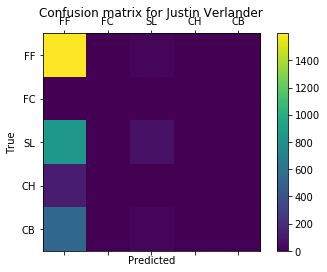

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cfm_verlander)
plt.title('Confusion matrix for Justin Verlander')
fig.colorbar(cax)
ax.set_xticklabels([''] + verlander_labels)
ax.set_yticklabels([''] + verlander_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('verlander_cfm.jpg')
plt.show()


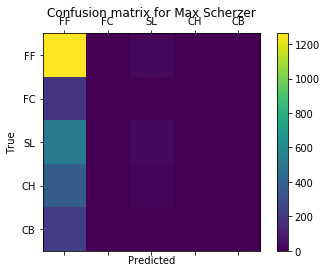

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cfm_scherzer)
plt.title('Confusion matrix for Max Scherzer')
fig.colorbar(cax)
ax.set_xticklabels([''] + scherzer_labels)
ax.set_yticklabels([''] + scherzer_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('scherzer_cfm.jpg')
plt.show()

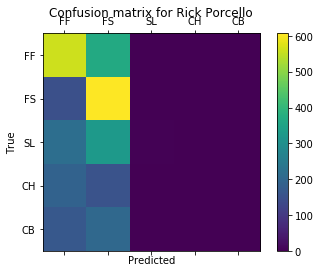

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cfm_porcello)
plt.title('Confusion matrix for Rick Porcello')
fig.colorbar(cax)
ax.set_xticklabels([''] + porcello_labels)
ax.set_yticklabels([''] + porcello_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('porcello_cfm.jpg')
plt.show()